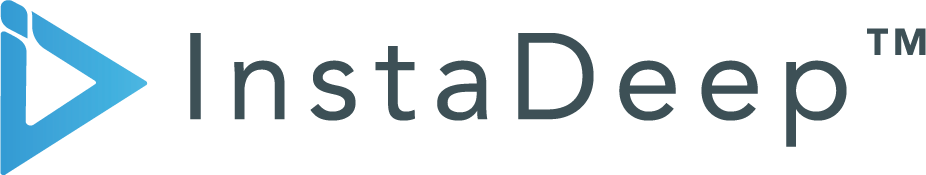
<center><h1><strong>InstaDeep - Computational Biology Technical Test</strong></h1></center>

#**Load the data**

The data were hosted in my Google drive. No need to do the same, simply make sure that the data follow the following structure:

```bash
├── random_split
│   ├── train
│   ├── test
│   ├── dev
├── InstaDeep.ipynb
```

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!cp /content/drive/MyDrive/archive.zip /content/data.zip

In [3]:
!unzip /content/data.zip

Archive:  /content/data.zip
  inflating: random_split/dev/data-00000-of-00010  
  inflating: random_split/dev/data-00001-of-00010  
  inflating: random_split/dev/data-00002-of-00010  
  inflating: random_split/dev/data-00003-of-00010  
  inflating: random_split/dev/data-00004-of-00010  
  inflating: random_split/dev/data-00005-of-00010  
  inflating: random_split/dev/data-00006-of-00010  
  inflating: random_split/dev/data-00007-of-00010  
  inflating: random_split/dev/data-00008-of-00010  
  inflating: random_split/dev/data-00009-of-00010  
  inflating: random_split/random_split/dev/data-00000-of-00010  
  inflating: random_split/random_split/dev/data-00001-of-00010  
  inflating: random_split/random_split/dev/data-00002-of-00010  
  inflating: random_split/random_split/dev/data-00003-of-00010  
  inflating: random_split/random_split/dev/data-00004-of-00010  
  inflating: random_split/random_split/dev/data-00005-of-00010  
  inflating: random_split/random_split/dev/data-00006-of-00010

#**Data analysis**

We first prepare the datasets by concatenating the data in each of the 3 splits. So we end up with 3 Pandas Dataframes with the following columns:

```
family_id sequence_name family_accession aligned_sequence sequence
```

We first need to make sure that no data are missing, in which case we would drop the incomplete instances.

In [4]:
import pandas as pd
from pathlib import Path
import os
import seaborn as sns
from collections import Counter
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

In [5]:
root_dir = Path("/content/random_split")
train_dir, test_dir, dev_dir = root_dir / "train", root_dir / "test", root_dir / "dev"

In [6]:
# Load each file and concatenate all the sequences
# into a single dataframe
def concatenate_data(pathname):
  filenames = [pathname / f for f in os.listdir(pathname)]
  df, total_instances = pd.DataFrame(), 0
  for f in filenames:
    temp_df = pd.read_csv(f) # read csv and convert it to DataFrame
    df = df.append(temp_df) # concatenate DataFrames
    total_instances += len(temp_df.index)
  return df, total_instances

In [7]:
train_df, total_train = concatenate_data(train_dir)
test_df, total_test = concatenate_data(test_dir)
dev_df, total_dev = concatenate_data(dev_dir)

In [8]:
total_instances = total_train + total_test + total_dev
print(f'Train data account for {100*round(total_train/total_instances, 2)}% ({total_train}) of the dataset')
print(f'Test data account for {100*round(total_test/total_instances, 2)}% ({total_test}) of the dataset')
print(f'Dev data account for {100*round(total_dev/total_instances, 2)}% ({total_dev}) of the dataset')

Train data account for 81.0% (1086741) of the dataset
Test data account for 9.0% (126171) of the dataset
Dev data account for 9.0% (126171) of the dataset


In [8]:
train_df.head(10)

,family_id,sequence_name,family_accession,aligned_sequence,sequence
0,COX7B,Q4SPX5_TETNG/1-75,PF05392.11,MYRFAKAAVN.ISSQAARQ..VRHG..SSAPQDFHSKYGTGIMIGG...,MYRFAKAAVNISSQAARQVRHGSSAPQDFHSKYGTGIMIGGAVFCT...
1,ABC_transp_aux,D5ENZ5_CORAD/30-298,PF09822.9,QWDLTAAKEHSLSEAAKTQLNQL..ET....P.......VTIRYYA...,QWDLTAAKEHSLSEAAKTQLNQLETPVTIRYYASVGDNTIPYALRV...
2,SH3_13,D5WVT4_KYRT2/591-655,PF18335.1,LNPRLQGEV..NPP.G...SD.KPEVQ..A....GGRV...FRLGD...,LNPRLQGEVNPPGSDKPEVQAGGRVFRLGDRVMQVRNDYQKEVFNG...
3,MucBP_2,N1ZKJ4_9LACO/1081-1157,PF17965.1,QSA..QITFI...DVT.DNK..VISS........SEVVGNYG.DKI...,QSAQITFIDVTDNKVISSSEVVGNYGDKIIFTDNPEELIKQLEAQG...
4,Ribosomal_S13_N,D7FP13_ECTSI/24-78,PF08069.12,.......SGGK..GISKSSLPYRRSAPSWLK..V..SAQEVTEHVC...,SGGKGISKSSLPYRRSAPSWLKVSAQEVTEHVCKLAKKGLTPSQIG...
5,Acyl-thio_N,K3XXY3_SETIT/1-127,PF12590.8,MAAS..IAASAFFP...GSPAPAPAAPKNG...LGERPESLDVRGV...,MAASIAASAFFPGSPAPAPAAPKNGLGERPESLDVRGVAAKPGSSS...
6,DUF3535,E0VSS7_PEDHC/522-975,PF12054.8,VWRNLIVNS.....HLNTLLMAACPCFGGWLCLLMQNSKT.....A...,VWRNLIVNSHLNTLLMAACPCFGGWLCLLMQNSKTAFDPNLLIFED...
7,Peptidase_M16_M,V2YR86_MONRO/435-746,PF16187.5,FRFIE.KRK.PDDYATRIAENM.AK......PYPRE........LL...,FRFIEKRKPDDYATRIAENMAKPYPRELLLVAPSVTWNWGDQYESG...
8,TAF1D,L8Y6G3_TUPCH/24-227,PF15333.6,SGSSLFKTQCVPSSPTRRQRN.QIQKCVYSPKNIKE.DSSSYSSFE...,SGSSLFKTQCVPSSPTRRQRNQIQKCVYSPKNIKEDSSSYSSFEPK...
9,DUF1015,M9SF81_METAX/5-394,PF06245.11,.LPFKG..YRPNI.RAG.....ET..IADRVSPPYD.VIGEEELRQ...,LPFKGYRPNIRAGETIADRVSPPYDVIGEEELRQLQSKRENVTNLT...


In [25]:
print(f'Number of missing values in train data: {train_df.isnull().sum()}')

Number of missing values in train data: family_id           0
sequence_name       0
family_accession    0
aligned_sequence    0
sequence            0
dtype: int64


In [26]:
print(f'Number of missing values in dev data: {dev_df.isnull().sum()}')

Number of missing values in dev data: family_id           0
sequence_name       0
family_accession    0
aligned_sequence    0
sequence            0
dtype: int64


In [27]:
print(f'Number of missing values in test data: {test_df.isnull().sum()}')

Number of missing values in test data: family_id           0
sequence_name       0
family_accession    0
aligned_sequence    0
sequence            0
dtype: int64


No data are missing. We can keep all the instances in each dataset for the moment.

##**Most represented family classes**

The task at hand is to predict the family a particular protein belongs to. To do so, the sequence feature is used to predict the family_accession attribute (label). 
<br>
* There is an obvious connection between the family_id and family_accession as they have a 1-to-1 relationship: family_id is a readable name for each family_accession code. Therefore, we can use either of them as target in our training framework as we will one-hot encode their values and the result will be exactly the same.
<br>
* There is also a blatant correlation between sequence and aligned_sequence: the aligned_sequence accounts for the seeds (gaps) in the real complete protein chain and hence is richer than sequence  as it gives more structural information about the interactions between amino acids. However, using the aligned sequences require encoding the seeds as well and hence more memory space during training. For the purpose of this test, we will only use the sequence feature which we will need to shrink anyway: allocating the available power and memory to encode more amino acids and not seeds seems more relevant for our classification task. Of course, with unlimited resources, the aligned sequence would be retained: the seeds are useful temporal information when training a LSTM- or Transformer-based model.
<br>
* As shown below, the number of classes (families) is different depending on the dataset: 17929 for training, 13071 for dev and test. We need to select our classes for 3 reasons: there is a very large number of classes (thus the need for a ~18000-dimensional vector as labels during training) which means higher computational power; a large number of classes in the training dataset are not in the other 2 so we won't be able to see how the model performs for those classes and generalisation will not be ensured; last but not least, we have a very imbalanced dataset, i.e some classes are overrepresented (> 1000 instances) and some underrepresented. For instance, 15161 out of the 17929 labels in the training dataset only have less than 100 instances; in comparison, only 289 classes have more than 500 instances. Some methods such as oversampling, undersampling and SMOTE (Synthetic Minority Oversampling Technique) to tackle this issue; however, the inequalities are tremendous and as we said, we will need to reduce the labels space anyway because of reasons of feasibility. We therefore decide to only keep a smaller proportion of classes that will be present in all 3 datasets. We will choose this proportion later in the data analysis. Those classes will be selected as the most represented, thus ensuring that we have largely enough data for training and preventing overfitting.

In [89]:
train_df['sequence_name'].nunique()

1086741

In [88]:
train_df.groupby('family_id')['sequence_name'].nunique().sort_values(ascending=False)

family_id
Methyltransf_25    3637
LRR_1              1927
Acetyltransf_7     1761
His_kinase         1537
Bac_transf         1528
                   ... 
Bacillus_PapR         1
Adeno_PV              1
Adeno_PIX             1
Thx                   1
TcpF                  1
Name: sequence_name, Length: 17929, dtype: int64

In [24]:
train_df.groupby('family_accession')['sequence_name'].nunique().sort_values(ascending=False)

family_accession
PF13649.6     3637
PF00560.33    1927
PF13508.7     1761
PF06580.13    1537
PF02397.16    1528
              ... 
PF17601.2        1
PF17600.2        1
PF11570.8        1
PF17599.2        1
PF05550.11       1
Name: sequence_name, Length: 17929, dtype: int64

In [10]:
# Count the number classes with less than 100 instances in training 
(train_df.groupby('family_accession')['sequence_name'].nunique().sort_values(ascending=False).to_numpy() < 100).sum()

15161

In [11]:
# Count the number classes with more than 1000 instances in training 
(train_df.groupby('family_accession')['sequence_name'].nunique().sort_values(ascending=False).to_numpy() > 500).sum()

289

In [ ]:
dev_df.groupby('family_accession')['sequence_name'].nunique().sort_values(ascending=False)

family_accession
PF13649.6     454
PF00560.33    240
PF13508.7     219
PF06580.13    192
PF02397.16    190
             ... 
PF12596.8       1
PF16318.5       1
PF12595.8       1
PF14948.6       1
PF05111.12      1
Name: sequence_name, Length: 13071, dtype: int64

In [11]:
# Count the number classes with less than 100 instances in dev 
(dev_df.groupby('family_accession')['sequence_name'].nunique().sort_values(ascending=False).to_numpy() < 100).sum()

13016

In [ ]:
test_df.groupby('family_accession')['sequence_name'].nunique().sort_values(ascending=False)

family_accession
PF13649.6     454
PF00560.33    240
PF13508.7     219
PF06580.13    192
PF02397.16    190
             ... 
PF12596.8       1
PF16318.5       1
PF12595.8       1
PF14948.6       1
PF05111.12      1
Name: sequence_name, Length: 13071, dtype: int64

In [12]:
# Count the number classes with less than 100 instances in test 
(test_df.groupby('family_accession')['sequence_name'].nunique().sort_values(ascending=False).to_numpy() < 100).sum()

13016

In [12]:
def plot_count(df, ax, index, name):
  sequence_counts = df['sequence'].str.len()
  sns.histplot(sequence_counts, kde=True, ax=ax[index])
  ax[index].set_title(f'Sequence lengths in {name} dataset')
  ax[index].set(xlabel='Sequence length', ylabel='Count')

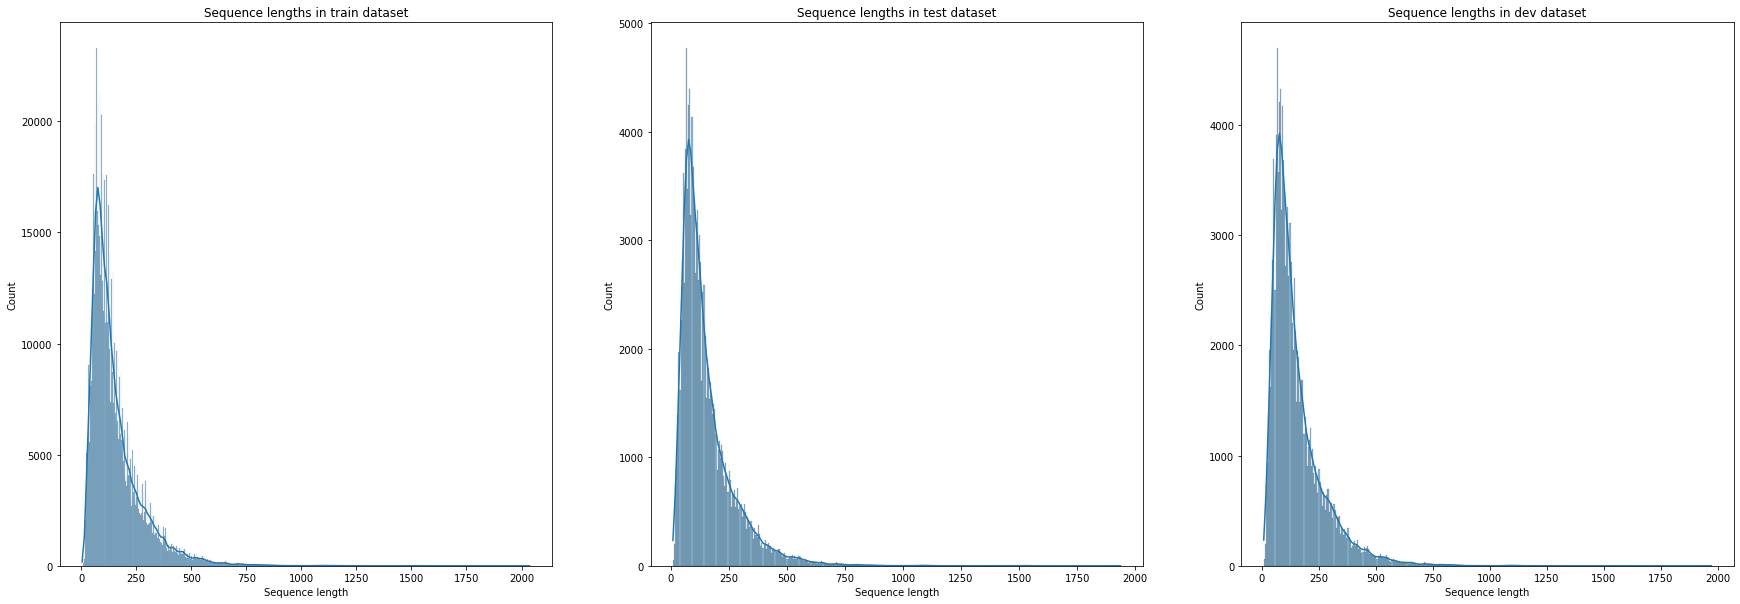

In [15]:
fig, ax = plt.subplots(1, 3, figsize=(30, 10))

plot_count(train_df, ax, 0, 'train')
plot_count(test_df, ax, 1, 'test')
plot_count(dev_df, ax, 2, 'dev')

In [19]:
print(f'Mean for training sequence length: {train_df["sequence"].str.len().mean()}')
print(f'Standard deviation for training sequence length: {train_df["sequence"].str.len().std()}')
print(f'Mean for dev sequence length: {dev_df["sequence"].str.len().mean()}')
print(f'Standard deviation for dev sequence length: {dev_df["sequence"].str.len().std()}')
print(f'Mean for test sequence length: {test_df["sequence"].str.len().mean()}')
print(f'Standard deviation for test sequence length: {test_df["sequence"].str.len().std()}')

Mean for training sequence length: 155.37997094063812
Standard deviation for training sequence length: 120.12319925495248
Mean for dev sequence length: 154.2222063707191
Standard deviation for dev sequence length: 118.2782498111793
Mean for test sequence length: 154.16684499607675
Standard deviation for test sequence length: 118.37670584022541


As shown above, the vast majority of the sequences' lengths in the datasets do not exceed 250 amino acids with a mean around 150 characters for all 3 datasets. As we will see, each amino acid will be encoded but the number of amino acids must be the same across all instances. We can't have input data in our model with different lengths, we therefore have to fix a max sequence length, large enough to contain the meaningful information we need to determine the protein family.
For computational reasons only, we can't simply select the highest sequence length in the datasets as it would require too much memeory: we will truncate every sequence with a fixed length of 100 (200 is still a bit too big for training the model in Colab).

##**Amino acid frequencies**

As shown below, the amino acids B, U, O and Z are largely underrepresented. As we will later need to encode and embed those amino acids, hence create a multi dimensional vector for each of them, we can reasonly drop them and simply put encode them as 0 before using the embedding layer. We can also assume that their influence if there is one, can be largely undermined and hence justifies our decision. We also note that not all the amino acids present during training are found during evaluation or testing; like for the missing target labels, dropping those 4 amino acids makes sense in such a case as they won't even matter in making the decision on the test data.

In [9]:
def plot_frequencies(df, ax, index, name):
  frequencies = Counter()
  for seq in df['sequence'].to_numpy():
    frequencies += Counter(seq)

  frequency_df = pd.DataFrame({ 'Amino acid': frequencies.keys(), 'Frequency': frequencies.values()}).sort_values('Frequency', ascending=False).reset_index()[['Amino acid', 'Frequency']]

  ax[index].set_title(f'Frequency in {name} dataset')
  sns.barplot(data=frequency_df, x='Amino acid', y='Frequency', ax=ax[index])

  return frequency_df

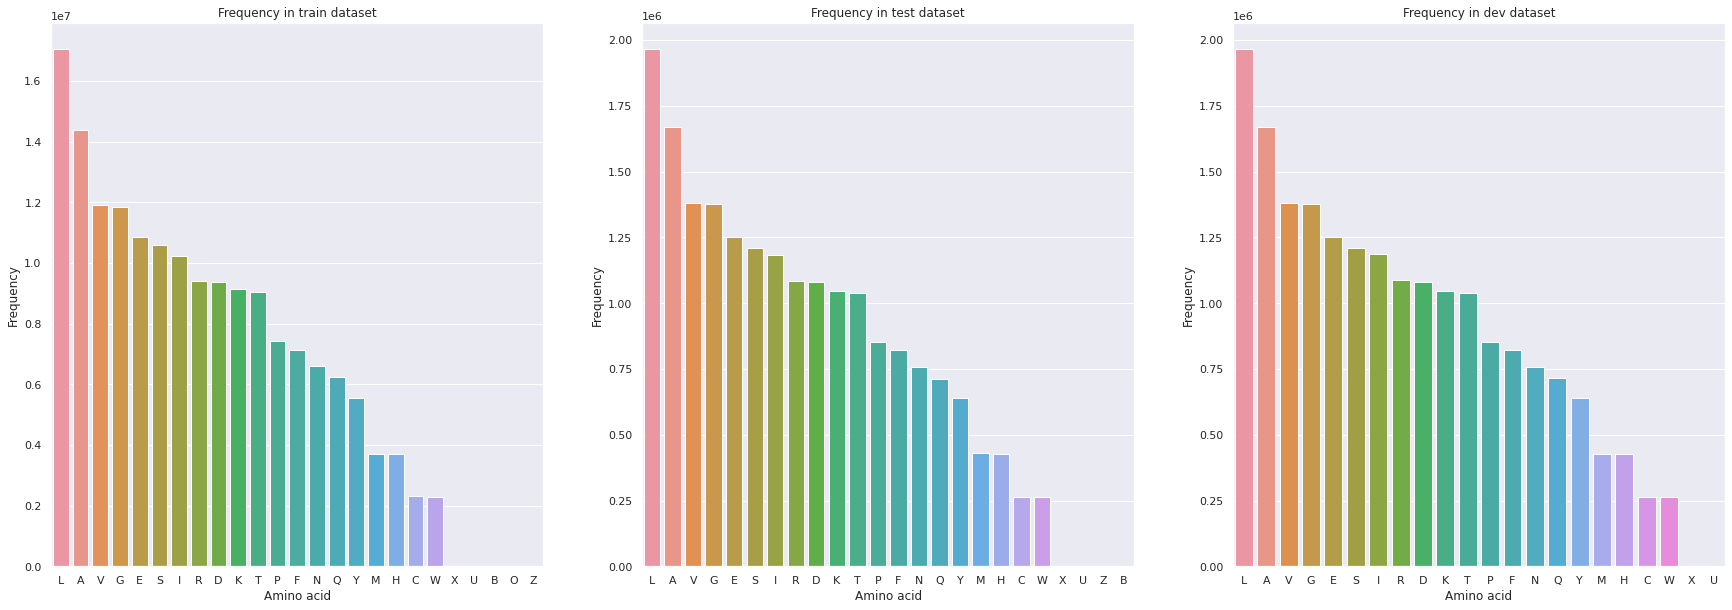

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(30, 10))
train_frequencies_df = plot_frequencies(train_df, ax, 0, 'train')
test_frequencies_df = plot_frequencies(test_df, ax, 1, 'test')
dev_frequencies_df = plot_frequencies(dev_df, ax, 2, 'dev')

In [ ]:
print(f'Training frequencies - unique amino acids: {len(train_frequencies_df["Amino acid"])}')
print(train_frequencies_df)
print(f'\nDev frequencies - unique amino acids: {len(dev_frequencies_df["Amino acid"])}')
print(dev_frequencies_df)
print(f'\nTest frequencies - unique amino acids: {len(test_frequencies_df["Amino acid"])}')
print(test_frequencies_df)

Training frequencies - unique amino acids: 25
   Amino acid  Frequency
0           L   17062816
1           A   14384873
2           V   11913147
3           G   11845579
4           E   10859966
5           S   10597822
6           I   10234455
7           R    9406165
8           D    9371097
9           K    9127832
10          T    9034110
11          P    7441084
12          F    7130287
13          N    6616976
14          Q    6250389
15          Y    5556597
16          M    3708948
17          H    3704587
18          C    2316115
19          W    2293257
20          X       1505
21          U        119
22          B         33
23          O         18
24          Z          8

Dev frequencies - unique amino acids: 22
   Amino acid  Frequency
0           L    1967025
1           A    1667703
2           V    1382128
3           G    1376124
4           E    1249356
5           S    1210750
6           I    1185722
7           R    1085950
8           D    1080572
9           

##**Plot cumulative classes count**

We tried training the model using the whole training dataset, i.e with the 18000 classes included. Because of limited computational power, we need to drastically downsample the dataset by only keeping the N most represented classes. Here, we try N=1000. As we can see below, this accounts for 40% of the training data. Of course, with larger computational power, one can easily increase the number of classes retained and train the model on the whole dataset. We only chose to reduce the dataset that much to make the notebook runnable with the configuration mentioned in the test description. Let's note that the curve increase is very sharp at the beginning: as the list is sorted in the descending order, this means that there is only few classes with high numbers of instances. The majority of classes have less than 500 instances.



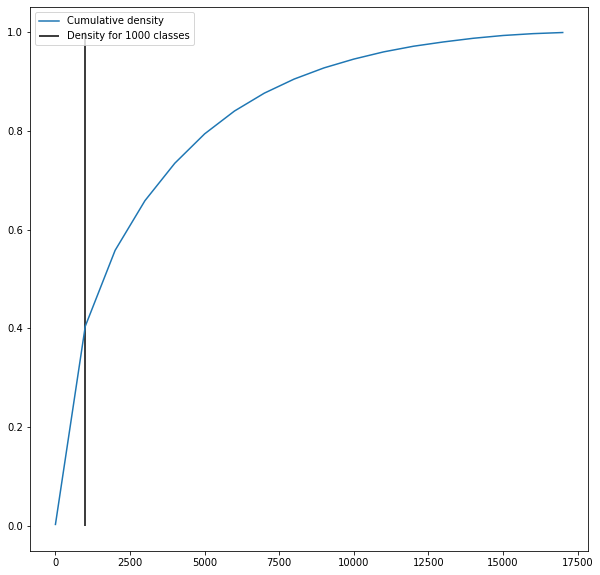

In [7]:
x = train_df.groupby('family_accession')['sequence_name'].nunique().sort_values(ascending=False)
y = [x[0]]
for i in range(1, len(x)):
  y.append(sum(x[:i]))
y = [c/y[-1] for c in y]
plt.figure(figsize=(10,10))
plt.plot(np.arange(len(y))[::1000], y[::1000], label="Cumulative density")
plt.vlines([1000], ymin=0, ymax=1, label="Density for 1000 classes")
plt.legend()

In [8]:
# Keep 1000 most represented classes
classes = x.index.to_numpy().tolist()[:1000]

train_df = train_df.loc[train_df['family_accession'].isin(classes)].reset_index()
test_df = test_df.loc[test_df['family_accession'].isin(classes)].reset_index()
dev_df = dev_df.loc[dev_df['family_accession'].isin(classes)].reset_index()

In [9]:
print(f'After selection, {len(train_df.index)} training instances')
print(f'After selection, {len(test_df.index)} test instances')
print(f'After selection, {len(dev_df.index)} dev instances')

After selection, 439493 training instances
After selection, 54378 test instances
After selection, 54378 dev instances


#**Classification**

We want to predict the class (target: family accession) of a protein given its sequence of amino acids (features). This a multiclass classification task. 
<br>
We can note that using the aligned sequence instead might more relevant as it accounts for the true connectionist nature of the protein, hence providing more information about it and potentially the family it belongs to. However, doing so will require more power as we would need more dimension to encode the seeds.
<br>
But we first need to preprocess the raw sequences before using them. As the class depends on the chronological order of amino acids, RNNs are likely to be a good solution as they can capture the relationships between a characters and its predecessors and successors (if bidirectional especially). Here, we will use a LSTM-based network to classify the data. The sequences will first be encoded using a vocabulary of the 21 amino acids retained during the data analysis, then embedded as 128-dimensional vectors. The LSTM output will be then be passed into a Dense layer followed by a softmax activation function. The final predictions will a 2000-dimensional vector representing the probability the sequence belongs to each of the 2000 families.

Transformers are known to perform a bit better on some NLP tasks. It would be worth checking what kind of results they could give on our dataset.

In [1]:
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import pandas as pd
from torch.utils.data import DataLoader, Dataset
from pathlib import Path
import numpy as np
import math
import time

##**Dataset**

In [2]:
# Vocabulary of amino acids that will be encoded as an integer and then vectorised 
# through the embedding layer
amino_acids = ['L', 'A', 'V', 'G', 'E', 'S', 'I', 'R', 'D', 'K', 'T', 
               'P', 'F', 'N', 'Q', 'Y', 'M', 'H', 'C', 'W', 'X']

# dictionary of integer encoding, e.g L --> 1, A --> 2, etc
prot_to_int = dict((p, i+1) for i, p in enumerate(amino_acids)) 

# Max sequence length selected during data analysis
max_length_seq = 100

# Alternative to encode amino acid as one hot vector instead of integers
def one_hot_encoding(sequence):
  integer_encoded = [prot_to_int[p] if p in prot_to_int.keys() else 0 for p in sequence]
  one_hot_encoded = []
  for i in integer_encoded:
    vector = np.zeros(len(amino_acids))
    if i > 0:
      vector[i-1] = 1
    one_hot_encoded.append(vector)
  return one_hot_encoded

def integer_encoding(sequence):
  """Return list of integers
  Encode a sequence of amino acid letters into a list of integers
  """
  integer_encoded = [prot_to_int[p] if p in prot_to_int.keys() else 0 for p in sequence]
  return integer_encoded

In [12]:
class ProteinDataset(Dataset):
    """Inherit the PyTorch Dataset object

    Parse the DataFrame into a list of one-hot encoded labels 
    and a list of integer encoded amino acids sequence of fixed length
    0-padding is applied if the sequence is too short"""
    def __init__(self, df, seed=42):
        self.seed = np.random.RandomState(seed)
        self.data, self.labels = self.preprocessing(df)

    def preprocessing(self, df):
        """Take the raw dataframe as input and create a list of
        encoded amino acid sequences and a list of one-hot encoded labels"""
        labels_dict = dict((lab, i) for i, lab in enumerate(classes))
        labels = []
        for label in df['family_accession'].to_numpy():
          vector = np.zeros(1000)
          vector[labels_dict[label]] = 1 # label one-hot encoding
          labels.append(vector)

        data = []
        for seq in df['sequence'].to_numpy():
            integer_encoded = integer_encoding(seq)
            if len(integer_encoded) >= max_length_seq:
                integer_encoded = integer_encoded[:max_length_seq] # truncate if too large
            else:
                integer_encoded += [0]*(max_length_seq-len(integer_encoded)) # 0-padding
            data.append(integer_encoded)
        return data, labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, index):
        return torch.tensor(self.data[index]), torch.tensor(self.labels[index])

##**Model**

In [13]:
use_cuda = torch.cuda.is_available()
device = torch.device('cuda' if use_cuda else 'cpu')
cuda_options = { 'num_workers': 0, 'pin_memory': True } if use_cuda else {}

print(f'-------------- {device} will be used -----------------')

-------------- cuda will be used -----------------


In [14]:
class ProteinModel(nn.Module):
  def __init__(self, input_dim, embedding_dim, lstm_output_dim, num_classes, batch_size, device):
    super(ProteinModel, self).__init__()

    self.batch_size = batch_size
    self.hidden_size = lstm_output_dim
    self.device = device

    self.embedding = nn.Embedding(input_dim, embedding_dim) # Embed each of the 22 integers into a 128-dimensional vector
    self.rnn = nn.LSTM(embedding_dim, lstm_output_dim, num_layers=2, bidirectional=True)
    self.dropout = nn.Dropout(p=0.2) # Regularise training and prevent overfitting
    self.classifier = nn.Sequential( # Final classifier that outputs the probas for each class
        nn.Linear(lstm_output_dim, num_classes),
        nn.Softmax()
    )

  def forward(self, x, batch_size=None):
    embeds = self.embedding(x)
    embeds = embeds.permute(1, 0, 2)

    if batch_size is None:
      h_0 = Variable(torch.zeros(4, self.batch_size, self.hidden_size).to(self.device)) # Initial hidden state of the LSTM
      c_0 = Variable(torch.zeros(4, self.batch_size, self.hidden_size).to(self.device)) # Initial cell state of the LSTM
    else:
      h_0 = Variable(torch.zeros(4, batch_size, self.hidden_size).to(self.device))
      c_0 = Variable(torch.zeros(4, batch_size, self.hidden_size).to(self.device))

    output, (final_hidden_state, final_cell_state) = self.rnn(embeds, (h_0, c_0))
    final_output = self.classifier(final_hidden_state[-1])
    return final_output #self.classifier(final_output.view(len(sentence), -1))

  def __call__(self, x, batch_size=None):
    return self.forward(x, batch_size)

##**Create datasets from DataFrames**

In [15]:
train_dataset = ProteinDataset(df=train_df)
dev_dataset = ProteinDataset(df=dev_df)
test_dataset = ProteinDataset(df=test_df)

train_dataloader = DataLoader(dataset=train_dataset, batch_size=512, shuffle=True, drop_last=True, **cuda_options)
dev_dataloader = DataLoader(dataset=dev_dataset, batch_size=256, drop_last=True, **cuda_options)
test_dataloader = DataLoader(dataset=test_dataset, batch_size=256, drop_last=True, **cuda_options)

In [17]:
torch.cuda.empty_cache()

##**Initialise hyperparameters**

In [16]:
input_dim = len(amino_acids)+1    # +1 for other amino acids 
embedding_dim = 128               # dimension of the embedded vector
lstm_output_dim = 128             # dimension of lstm hidden state
num_classes = 1000                # selected number of target families 
batch_size = 512

epochs = 30
learning_rate = 0.0005
betas = (0.9, 0.999)
weight_decay = 10e-5

model = ProteinModel(
    batch_size=batch_size,
    input_dim=input_dim, 
    embedding_dim=embedding_dim,
    lstm_output_dim=lstm_output_dim, 
    num_classes=num_classes,
    device=device).to(device)

optimizer = optim.Adam(model.parameters(), lr=learning_rate, betas=betas, weight_decay=weight_decay)

In [17]:
print(model)

ProteinModel(
  (embedding): Embedding(22, 128)
  (rnn): LSTM(128, 128, num_layers=2, bidirectional=True)
  (dropout): Dropout(p=0.2, inplace=False)
  (classifier): Sequential(
    (0): Linear(in_features=128, out_features=1000, bias=True)
    (1): Softmax(dim=None)
  )
)


**Early stopping is used to stop trainig when the validation loss starts increasing. This prevents the model from overfitting the training dataset.**
A tolerance is introduced: we wait for the loss to start decreasing again before stopping training.

In [18]:
"""Code from https://github.com/Bjarten/early-stopping-pytorch/blob/master/pytorchtools.py"""
class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False, delta=0, path='checkpoint.pt', trace_func=print):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
            path (str): Path for the checkpoint to be saved to.
                            Default: 'checkpoint.pt'
            trace_func (function): trace print function.
                            Default: print            
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path
        self.trace_func = trace_func
    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            self.trace_func(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

##**Training**

**The loss is a classic Categorical Cross Entropy as we are dealing with a multiclass classification task.**

In [21]:
def compute_loss(predicted_probas, labels):
    labels = labels.float()
    probas = torch.clamp(predicted_probas, min=1e-5, max=1.-1e-5) # ensures no log(0) or log(1)
    negative_log_likelihood = - 1. * (labels * torch.log(probas) + (1. - labels) * torch.log(1. - probas))

    return negative_log_likelihood.sum()

def compute_classification_error(predicted_probas, labels):
    _, predicted_indices = torch.max(predicted_probas.float(), 1)
    _, indices = torch.max(labels.float(), 1)
    error = 1. - indices.eq(predicted_indices).cpu().float().mean().item()
    return error

def compute_accuracy(predicted_probas, labels):
    correct = (torch.max(predicted_probas.data, 1)[1] == torch.max(labels.data, 1)[1]).sum().item()
    return correct/len(labels)

early_stopping = EarlyStopping(verbose=True)

# Training
print('Start training model...')
start_time = time.time()
train_losses, avg_train_losses,  = [], []
dev_losses, avg_dev_losses = [], []
dev_accuracies, avg_dev_accuracies = [], []
for epoch in range(1, epochs+1):

    ########################
    #### Train the model ###
    ########################
    model.train()
    #cumulated_error = 0.
    for batch_idx, (seqs, labels) in enumerate(train_dataloader):
        seqs, labels = Variable(seqs.long().to(device)), Variable(labels.to(device))
        optimizer.zero_grad() # Prevent accumulation of gradients during training

        predictions = model(seqs)
        loss = compute_loss(predictions, labels) # Categorial Cross Entropy
        train_losses.append(loss.item())

        #error = compute_classification_error(predictions, labels)
        #cumulated_error += error

        loss.backward() # Backpropagation through the computational graph
        optimizer.step() # Update the model weights

    ########################
    ## Evaluate the model ##
    ########################
    model.eval()
    for batch_idx, (seqs, labels) in enumerate(dev_dataloader):
        seqs, labels = Variable(seqs.long().to(device)), Variable(labels.to(device))
        predictions = model(seqs, batch_size=256)
        loss = compute_loss(predictions, labels)
        dev_losses.append(loss.item())
        accuracy = compute_accuracy(predictions, labels)
        dev_accuracies.append(accuracy)

    train_loss = np.average(train_losses)
    dev_loss = np.average(dev_losses)
    avg_train_losses.append(train_loss)
    avg_dev_losses.append(dev_loss)
    dev_accuracy = np.average(dev_accuracies)
    avg_dev_accuracies.append(dev_accuracy)

    print(f'\nEpoch {epoch}/{epochs} - Train Loss: {train_loss:.5f} - Dev Error: {dev_loss:.5f} - Dev Accuracy: {dev_accuracy:.5f}')

    train_losses, dev_losses, dev_accuracies = [], [], []

    early_stopping(dev_loss, model) # Check if dev loss keeps decreasing

    # If the model overfits the training data, stop training
    if early_stopping.early_stop:
        print('Early stopping')
        break

duration = int(time.time() - start_time)
print('Trainig completed in {:02d}h:{:02d}m:{:02d}s'.format(duration // 3600, (duration % 3600 // 60), duration % 60))

Start training model...


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)



Epoch 1/30 - Train Loss: 2369.54833 - Dev Error: 679.21786 - Dev Accuracy: 0.64980
Validation loss decreased (inf --> 679.217865).  Saving model ...

Epoch 2/30 - Train Loss: 936.94498 - Dev Error: 331.36334 - Dev Accuracy: 0.83341
Validation loss decreased (679.217865 --> 331.363343).  Saving model ...

Epoch 3/30 - Train Loss: 511.67345 - Dev Error: 214.73820 - Dev Accuracy: 0.88659
Validation loss decreased (331.363343 --> 214.738201).  Saving model ...

Epoch 4/30 - Train Loss: 343.34418 - Dev Error: 157.40425 - Dev Accuracy: 0.91719
Validation loss decreased (214.738201 --> 157.404251).  Saving model ...

Epoch 5/30 - Train Loss: 252.66285 - Dev Error: 125.69117 - Dev Accuracy: 0.93205
Validation loss decreased (157.404251 --> 125.691171).  Saving model ...

Epoch 6/30 - Train Loss: 195.53231 - Dev Error: 105.61161 - Dev Accuracy: 0.94255
Validation loss decreased (125.691171 --> 105.611610).  Saving model ...

Epoch 7/30 - Train Loss: 155.60591 - Dev Error: 88.39216 - Dev Accura

##**Plot training metrics**

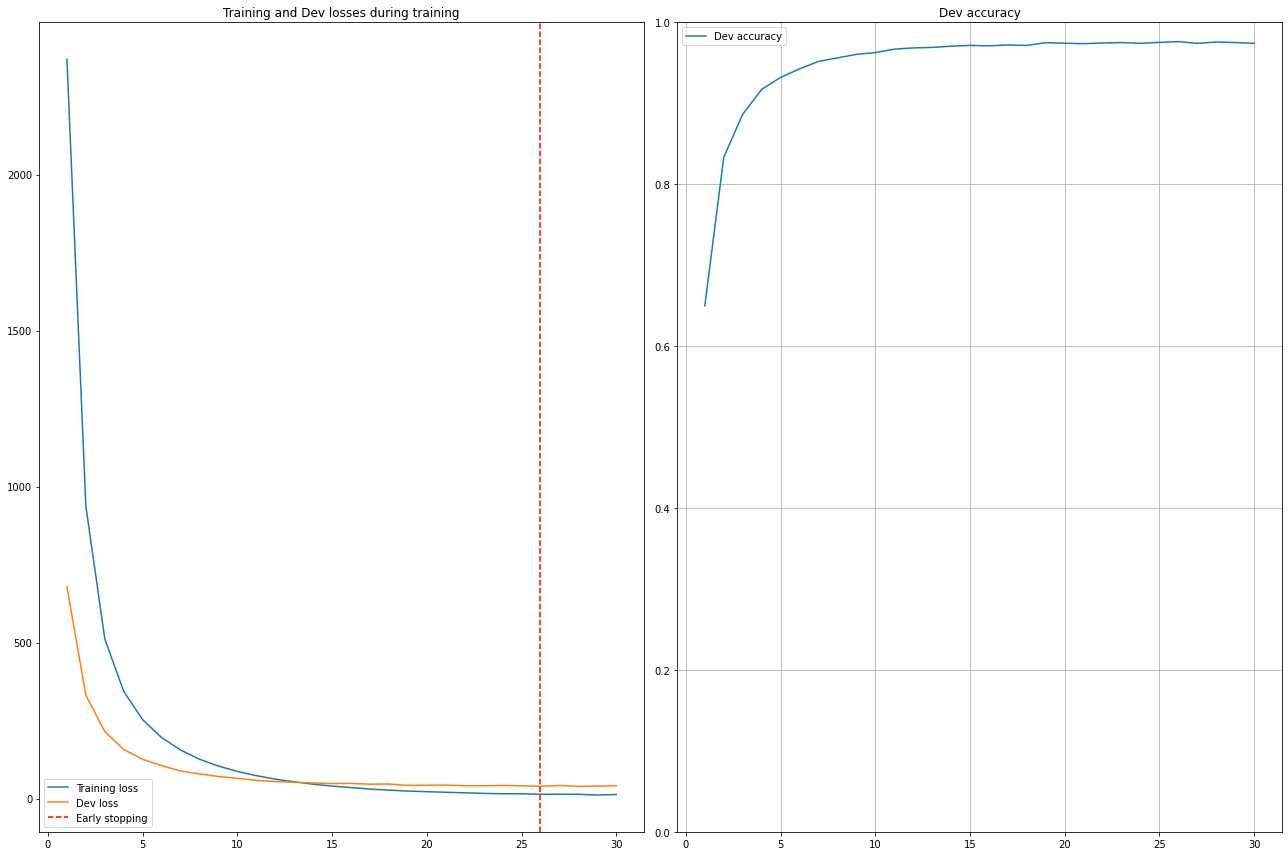

In [22]:
fig, axs = plt.subplots(1, 2, figsize=(18, 12))

plot_epochs = np.arange(1, len(avg_train_losses)+1)

min_dev_loss_epoch  = np.argmin(avg_dev_losses)+1

axs[0].plot(plot_epochs, avg_train_losses, label="Training loss")
axs[0].plot(plot_epochs, avg_dev_losses, label="Dev loss")
axs[0].axvline(min_dev_loss_epoch, linestyle='--', color='r', label="Early stopping")
axs[0].set_title('Training and Dev losses during training')

axs[1].plot(plot_epochs, avg_dev_accuracies, label="Dev accuracy")
axs[1].set_ylim(0, 1)
axs[1].set_title('Dev accuracy')

plt.grid(True)
axs[0].legend()
axs[1].legend()
plt.tight_layout()


We observe that the dev loss is lower than the training loss. This can be explained by 2 things:
* The training loss is computed before the dev loss, so has half-epoch discrepancy. A more accurate plot would shift the dev loss to the right.
* Regularisation through the dropout layer has been used during training but not during evaluation.

##**Final evalutation of the model on the test dataset**

In [23]:
# Load final model weights
model.load_state_dict(torch.load('checkpoint.pt'))

model.eval()
accuracies = []
for batch_idx, (seqs, labels) in enumerate(test_dataloader):
  seqs, labels = Variable(seqs.long().to(device)), Variable(labels.to(device))
  predictions = model(seqs, batch_size=256)
  accuracy = compute_accuracy(predictions, labels)
  accuracies.append(accuracy)

print(f'Average accuracy on the test dataset - {np.mean(accuracies):.5f}')

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Average accuracy on the test dataset - 0.97489


We obtain a final accuracy of 97.5% on the test dataset and 97.4% on the dev dataset. 